In [19]:
import glob
import regex as re
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline
%load_ext rpy2.ipython
%run ../airquality/data/gen_daily_targets.py

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [20]:
with open('../data/headers_mod.csv') as f:
    mod_headers = f.readlines()[0].split()
    
with open('../data/headers_obs.csv') as f:
    obs_headers = f.readlines()[0].split()
    
mod_headers, obs_headers

(['lon', 'lat', 'day', 'hour', 'AirPollutant', 'Concentration'],
 ['Countrycode',
  'Namespace',
  'AirQualityNetwork',
  'AirQualityStation',
  'AirQualityStationEoICode',
  'SamplingPoint',
  'SamplingProcess',
  'Sample',
  'AirPollutant',
  'AirPollutantCode',
  'AveragingTime',
  'Concentration',
  'UnitOfMeasurement',
  'DatetimeBegin',
  'DatetimeEnd',
  'Validity',
  'Verification'])

In [21]:
test = pd.read_csv('../data/targets.csv')
stations = pd.read_csv('../data/stations.csv')

In [22]:
observations = []
for folder in glob.glob('../data/obs/*'):
    for file in glob.glob('{}/*'.format(folder)):
        year = re.search('\d{4}', file)[0]
        station = 'ES{}A'.format(re.findall('\d{4}', file)[1])
        data = pd.read_csv(file, sep='\t', names=obs_headers)
        data['year'] = year
        data['station'] = station
        observations.append(data)
        
observations = pd.concat(observations)
observations = observations[[c for c in observations.columns if c not in [
    'Countrycode',
    'Namespace',
    'AirQualityNetwork',
    'AirQualityStation',
    'AirQualityStationEoICode',
    'SamplingPoint',
    'SamplingProcess',
    'AveragingTime',
    'UnitOfMeasurement',
    'AirPollutant',
    'AirPollutantCode',
    'Validity',
    'Verification',
    'DatetimeEnd',
    'Sample'
]]]
observations['datetime'] = pd.to_datetime(observations['DatetimeBegin'])
observations = observations.drop('DatetimeBegin', axis=1)
observations = observations.sort_values('datetime')
observations['day'] = observations['datetime'].apply(lambda dt: dt.date())
observations['time'] = observations['datetime'].apply(lambda dt: dt.time())
observations = pd.merge(observations, gen_daily_targets(observations)[['station', 'day', 'target']],
                        how='left', on=['station', 'day'])
observations.to_csv('../data/observations.csv')
observations.head(5)

,Concentration,year,station,datetime,day,time,target
0,19,2013,ES1992A,2013-01-01 01:00:00,2013-01-01,01:00:00,0
1,54,2013,ES1480A,2013-01-01 01:00:00,2013-01-01,01:00:00,0
2,11,2013,ES1856A,2013-01-01 01:00:00,2013-01-01,01:00:00,0
3,39,2013,ES1396A,2013-01-01 01:00:00,2013-01-01,01:00:00,0
4,55,2013,ES0691A,2013-01-01 01:00:00,2013-01-01,01:00:00,0


In [23]:
observations.groupby(['year', 'station']).agg({
    'Concentration': ['mean', 'std', 'var', 'count', 'min', 'max'],
    'datetime': ['min', 'max'],
    'target': ['sum']
})

Concentration                                        datetime  \
                      mean   std    var count min  max                 min   
year station                                                                 
2013 ES0691A         40.01 22.48 505.51  8643   1  135 2013-01-01 01:00:00   
     ES1396A         33.65 22.04 485.90  8627   1  163 2013-01-01 01:00:00   
     ES1438A         56.73 27.00 729.02  8420   1  253 2013-01-01 01:00:00   
     ES1480A         54.59 27.63 763.52  8656   1  229 2013-01-01 01:00:00   
     ES1679A         35.37 23.34 544.71  8625   1  183 2013-01-01 01:00:00   
     ES1856A         27.50 21.46 460.52  8496   1  147 2013-01-01 01:00:00   
     ES1992A         32.66 24.13 582.27  8617   1  183 2013-01-01 01:00:00   
2014 ES0691A         39.35 22.70 515.25  8585   3  141 2013-12-31 23:00:00   
     ES1396A         32.15 20.56 422.81  8592   3  158 2013-12-31 23:00:00   
     ES1438A         52.35 23.83 567.98  8562   7  170 2013-12-31 23:00:00   
     ES1480A         51.82 26.64 709.55  8592   3  202 2013-12-31 23:00:00   
     ES1679A         37.24 22.99 528.56  8660   1  132 2013-12-31 23:00:00   
     ES1856A         28.48 21.64 468.16  8613   1  157 2013-12-31 23:00:00   
     ES1992A         31.22 23.86 569.22  8597   1  189 2013-12-31 23:00:00   
2015 ES0691A         45.16 24.79 614.64  5691   4  166 2014-12-31 23:00:00   
     ES1396A         36.41 23.21 538.53  5469   1  172 2014-12-31 23:00:00   
     ES1438A         56.97 25.08 629.03  5617   8  178 2014-12-31 23:00:00   
     ES1480A         54.87 27.93 780.25  5554   1  217 2014-12-31 23:00:00   
     ES1679A         42.39 24.76 612.95  5745   1  172 2014-12-31 23:00:00   
     ES1856A         32.21 23.76 564.38  5750   1  169 2014-12-31 23:00:00   
     ES1992A         34.78 24.80 614.96  5622   1  195 2014-12-31 23:00:00   

                                 target  
                             max    sum  
year station                             
2013 ES0691A 2013-12-31 23:00:00    777  
     ES1396A 2013-12-31 23:00:00   1070  
     ES1438A 2013-12-31 23:00:00   3830  
     ES1480A 2013-12-31 23:00:00   3287  
     ES1679A 2013-12-31 23:00:00    622  
     ES1856A 2013-12-31 23:00:00   1026  
     ES1992A 2013-12-31 23:00:00   1933  
2014 ES0691A 2014-12-31 23:00:00    592  
     ES1396A 2014-12-31 23:00:00    498  
     ES1438A 2014-12-31 23:00:00   2443  
     ES1480A 2014-12-31 23:00:00   2642  
     ES1679A 2014-12-31 23:00:00    681  
     ES1856A 2014-12-31 23:00:00    877  
     ES1992A 2014-12-31 23:00:00   1508  
2015 ES0691A 2015-12-31 23:00:00   1249  
     ES1396A 2015-12-31 23:00:00    733  
     ES1438A 2015-12-31 23:00:00   1980  
     ES1480A 2015-12-31 23:00:00   2111  
     ES1679A 2015-12-31 23:00:00   1167  
     ES1856A 2015-12-31 23:00:00    945  
     ES1992A 2015-12-31 23:00:00   1140

In [24]:
models = []
for folder in glob.glob('../data/mod/*'):
    for file in glob.glob('{}/*'.format(folder)):
        year = re.search('\d{4}', file)[0]
        station = 'ES{}A'.format(re.findall('\d{4}', file)[-1])
        data = pd.read_table(file, sep='\s+', names=mod_headers)
        data['days_ahead'] = (data['day'] == data['day'].max()).astype(int)
        days_ahead = data.pivot(index='hour', columns='days_ahead', values='Concentration').reset_index()
        days_ahead['day'] = data.day.min()
        data = pd.merge(days_ahead, data[['lon', 'lat', 'hour']],
                        on='hour', how='left')\
            .rename(columns={0: 'pred_0_days', 1: 'pred_1_days'})\
            .drop_duplicates()
        data['year'] = year
        data['station'] = station
        models.append(data)
        
models = pd.concat(models)
models['datetime'] = pd.to_datetime(models['day'].astype(str) + ' ' + models['hour'].astype(str))
models = models.sort_values('datetime', ascending=True)
models['day'] = models['datetime'].apply(lambda dt: dt.date())
models['time'] = models['datetime'].apply(lambda dt: dt.time())
models = models[[c for c in models.columns if c not in [
    'AirPollutant',
    'hour'
]]].sort_values('datetime')
models.to_csv('../data/models.csv')
models.head(5)

,pred_0_days,pred_1_days,day,lon,lat,year,station,datetime,time
0,38.79,34.11,2013-01-01,2.15,41.39,2013,ES1438A,2013-01-01,00:00:00
0,28.53,27.48,2013-01-01,2.13,41.38,2013,ES1396A,2013-01-01,00:00:00
0,35.85,42.57,2013-01-01,2.20,41.40,2013,ES0691A,2013-01-01,00:00:00
0,31.81,31.59,2013-01-01,2.15,41.40,2013,ES1480A,2013-01-01,00:00:00
0,31.81,31.59,2013-01-01,2.15,41.43,2013,ES1856A,2013-01-01,00:00:00


In [27]:
models.groupby(['year', 'station']).agg({
    'pred_0_days': ['mean', 'std', 'var', 'count', 'min', 'max'],
    'pred_1_days': ['mean', 'std', 'var', 'count', 'min', 'max'],
    'datetime': ['min', 'max']
})

pred_0_days                                pred_1_days        \
                    mean   std    var count  min    max        mean   std   
year station                                                                
2013 ES0691A       40.05 28.29 800.10  8760 0.73 168.19       39.14 28.03   
     ES1396A       35.26 23.39 547.19  8760 3.93 181.36       34.51 22.81   
     ES1438A       49.35 29.49 869.59  8760 3.05 197.72       48.31 28.67   
     ES1480A       38.59 26.10 681.37  8760 2.82 159.23       37.50 25.37   
     ES1679A       49.35 29.49 869.59  8760 3.05 197.72       48.31 28.67   
     ES1856A       38.59 26.10 681.37  8760 2.82 159.23       37.50 25.37   
     ES1992A       35.26 23.39 547.19  8760 3.93 181.36       34.51 22.81   
2014 ES0691A       41.69 30.56 933.68  8760 1.43 189.77       40.11 30.48   
     ES1396A       36.01 23.77 565.03  8760 3.99 166.05       35.26 23.02   
     ES1438A       52.75 31.47 990.29  8760 4.03 225.09       51.04 30.55   
     ES1480A       40.40 27.23 741.38  8760 3.14 175.37       39.46 26.89   
     ES1679A       52.75 31.47 990.29  8760 4.03 225.09       51.04 30.55   
     ES1856A       40.40 27.23 741.38  8760 3.14 175.37       39.46 26.89   
     ES1992A       36.01 23.77 565.03  8760 3.99 166.05       35.26 23.02   
2015 ES0691A       38.40 30.05 903.02  8664 1.24 152.71       36.34 29.53   
     ES1396A       36.81 25.51 650.98  8664 3.38 179.40       36.33 24.82   
     ES1438A       48.63 30.55 933.05  8664 3.71 182.38       47.26 29.88   
     ES1480A       41.10 29.64 878.63  8664 3.77 194.44       40.29 28.71   
     ES1679A       48.63 30.55 933.05  8664 3.71 182.38       47.26 29.88   
     ES1856A       41.10 29.64 878.63  8664 3.77 194.44       40.29 28.71   
     ES1992A       36.81 25.51 650.98  8664 3.38 179.40       36.33 24.82   

                                        datetime                      
                var count  min    max        min                 max  
year station                                                          
2013 ES0691A 785.56  8759 1.14 164.75 2013-01-01 2013-12-31 23:00:00  
     ES1396A 520.29  8759 3.52 167.75 2013-01-01 2013-12-31 23:00:00  
     ES1438A 822.08  8759 2.12 195.16 2013-01-01 2013-12-31 23:00:00  
     ES1480A 643.64  8759 3.04 174.96 2013-01-01 2013-12-31 23:00:00  
     ES1679A 822.08  8759 2.12 195.16 2013-01-01 2013-12-31 23:00:00  
     ES1856A 643.64  8759 3.04 174.96 2013-01-01 2013-12-31 23:00:00  
     ES1992A 520.29  8759 3.52 167.75 2013-01-01 2013-12-31 23:00:00  
2014 ES0691A 928.95  8759 1.19 188.68 2014-01-01 2014-12-31 23:00:00  
     ES1396A 529.72  8759 4.43 171.68 2014-01-01 2014-12-31 23:00:00  
     ES1438A 933.51  8759 3.95 239.08 2014-01-01 2014-12-31 23:00:00  
     ES1480A 722.99  8759 3.98 183.37 2014-01-01 2014-12-31 23:00:00  
     ES1679A 933.51  8759 3.95 239.08 2014-01-01 2014-12-31 23:00:00  
     ES1856A 722.99  8759 3.98 183.37 2014-01-01 2014-12-31 23:00:00  
     ES1992A 529.72  8759 4.43 171.68 2014-01-01 2014-12-31 23:00:00  
2015 ES0691A 871.80  8664 1.09 145.46 2015-01-01 2015-12-31 23:00:00  
     ES1396A 616.16  8664 3.70 155.44 2015-01-01 2015-12-31 23:00:00  
     ES1438A 893.00  8664 2.86 159.00 2015-01-01 2015-12-31 23:00:00  
     ES1480A 824.51  8664 3.20 168.40 2015-01-01 2015-12-31 23:00:00  
     ES1679A 893.00  8664 2.86 159.00 2015-01-01 2015-12-31 23:00:00  
     ES1856A 824.51  8664 3.20 168.40 2015-01-01 2015-12-31 23:00:00  
     ES1992A 616.16  8664 3.70 155.44 2015-01-01 2015-12-31 23:00:00

In [28]:
observations.shape

(159733, 7)

In [29]:
models.shape

(183960, 9)

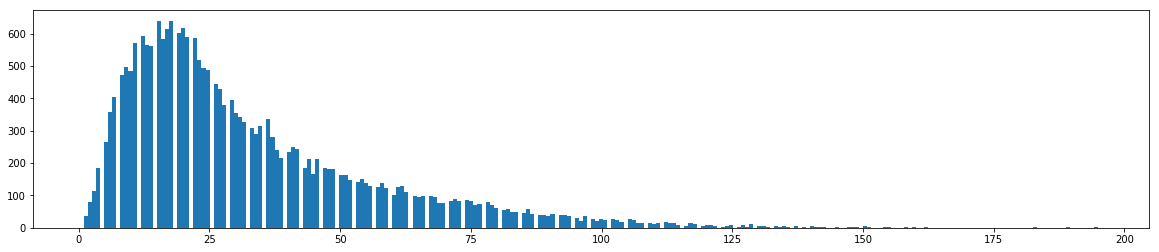

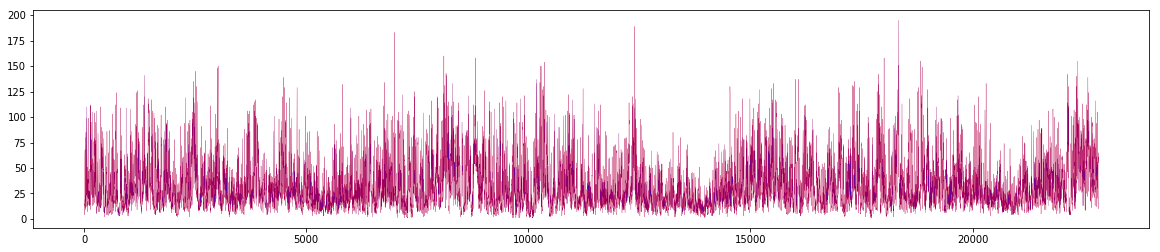

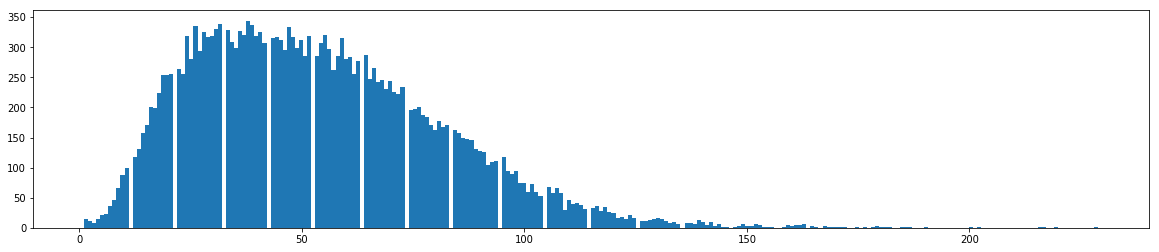

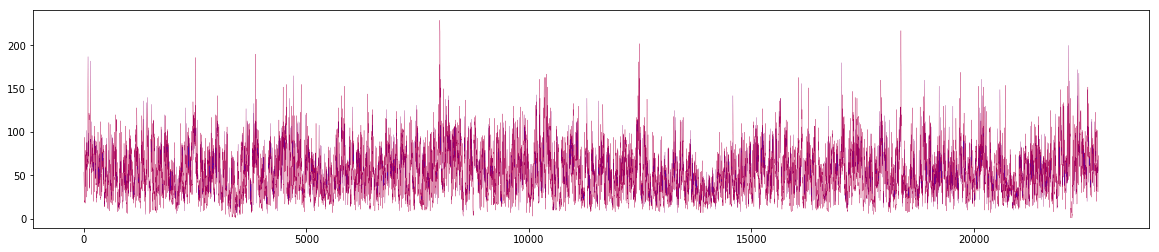

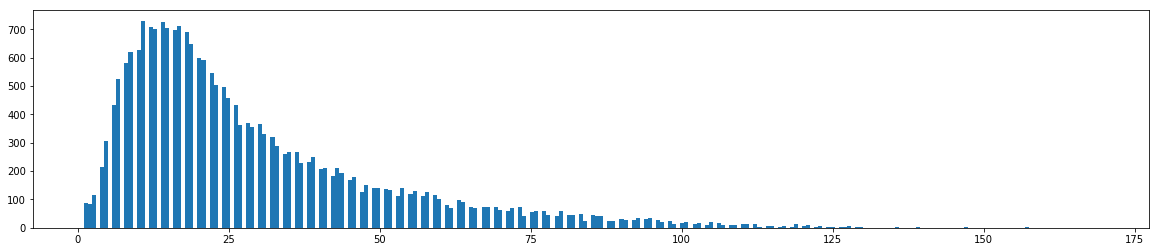

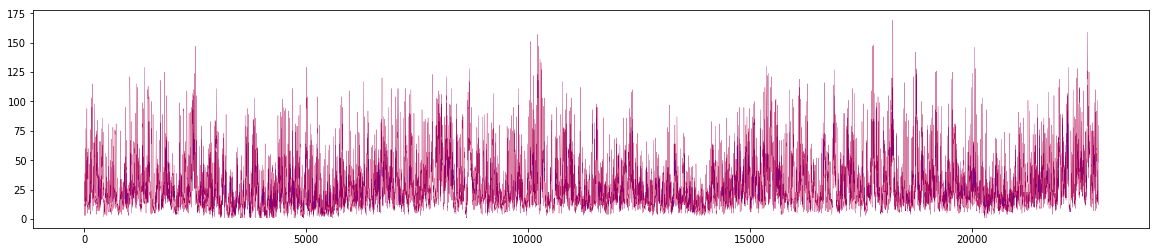

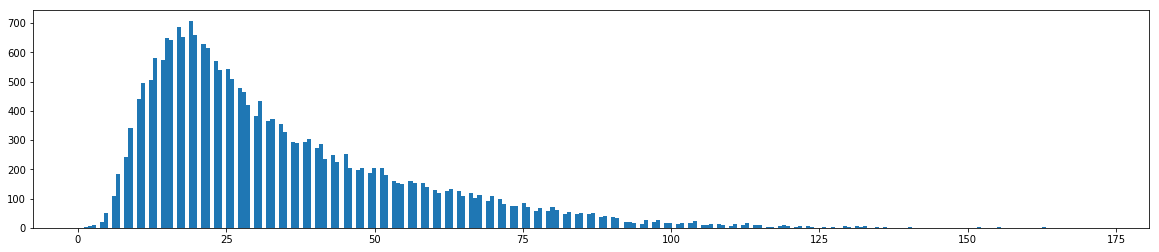

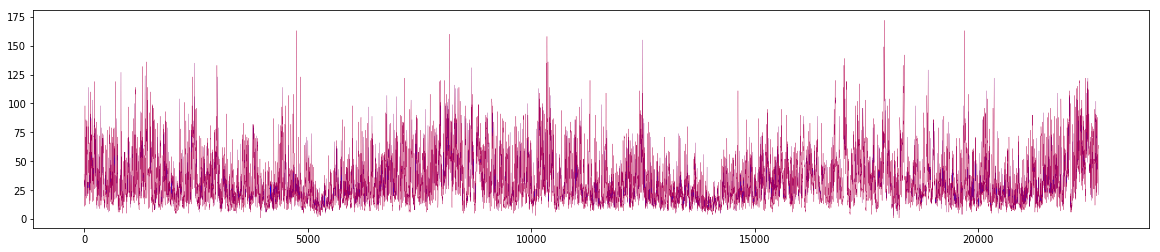

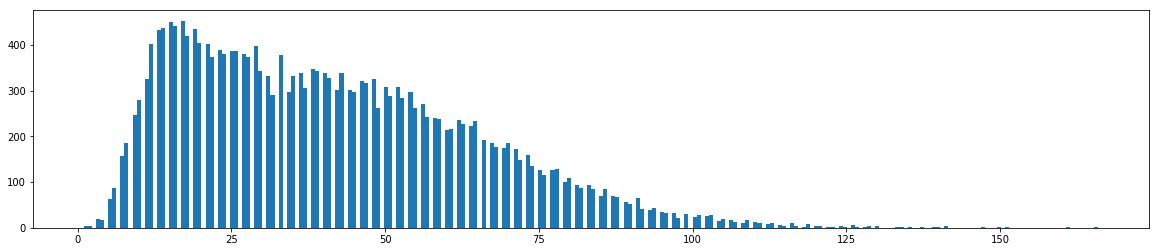

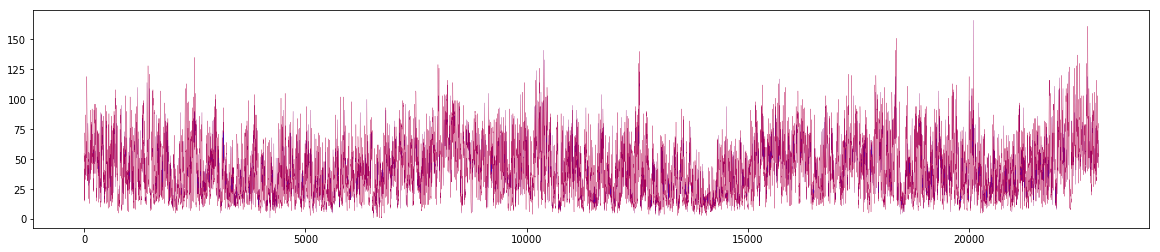

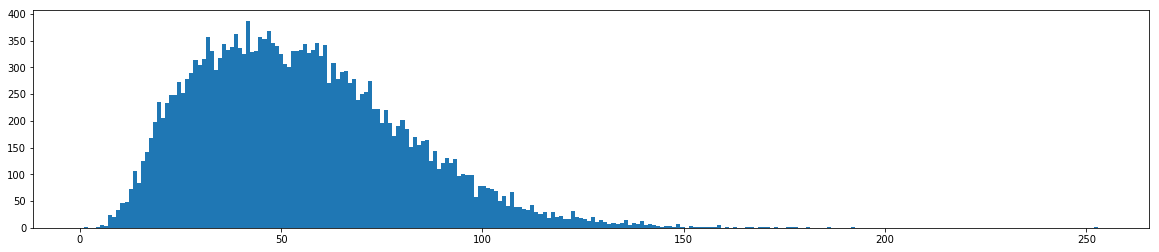

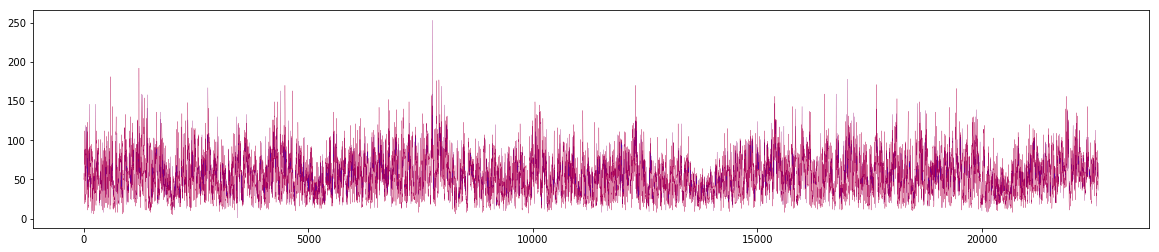

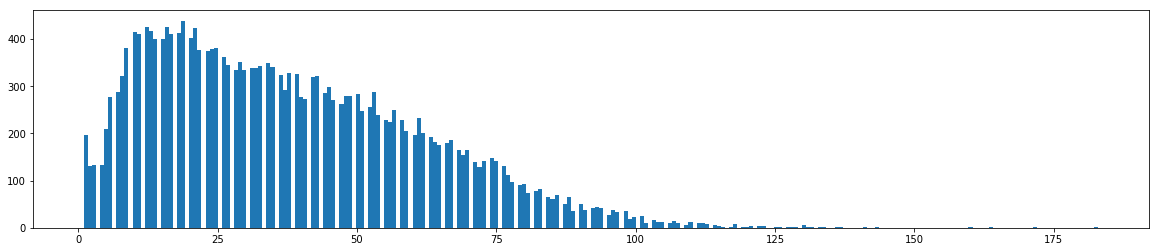

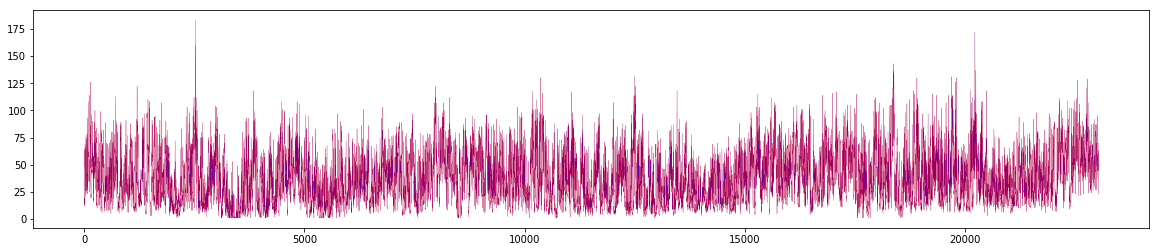

In [30]:
for s in observations['station'].unique():
    plt.figure(figsize=(20, 4))
    plt.hist(observations[observations['station'] == s]['Concentration'], bins=250)
    plt.figure(figsize=(20, 4))
    x_ax = list(range(0, observations[observations['station'] == s].shape[0]))
    plt.plot(x_ax, observations[observations['station'] == s]['Concentration'], 'r-', lw=.2)
    plt.plot(x_ax, observations[observations['station'] == s]['Concentration'], 'b--', lw=.1)